In [177]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import scipy.stats as scs

In [5]:
def parse_file(fn):
    with open(fn) as fh:
        lines = fh.readlines()
    
    result = {}
    for line in lines:
        if 'CCSD(T) total energy' in line:
            result['ccsdpt'] = float(line.strip().split()[-1])
        
        if 'Total CCSD energy [au]' in line:
            result['ccsd'] = float(line.strip().split()[-1])
            
        if 'MP2 energy [au]:' in line:
            result['mp2'] = float(line.strip().split()[-1])
            
        if 'Reference energy [au]' in line:
            result['hf'] = float(line.strip().split()[-1])
        
        if 'Nuclear repulsion energy [au]' in line:
            result['nn'] = float(line.strip().split()[-1])
            
    return result
    
parse_file("naphtalene/validation/validation/BNBCNNBBNC/run.log")

{'nn': 460.27180243292,
 'hf': -396.489249875867,
 'mp2': -397.76219414593,
 'ccsd': -397.83013461242,
 'ccsdpt': -397.893302310974}

In [15]:
def build_df():
    ret = []
    for folder in glob.glob("naphtalene/validation/validation/*/"):
        label = folder.split('/')[-2]
        res = parse_file(folder + "run.log")
        res['label'] = label
        res['nBN'] = len([_ for _ in label if _ == "N"])
        ret.append(res)
    return pd.DataFrame(ret)
explicit = build_df()

In [228]:
def parse_ranked(fn):
    with open(fn) as fh:
        lines = fh.readlines()
    
    order = []
    groups = []
    count = 0
    for line in lines:
        if "Found:" in line:
            label = ''.join(line.split('[')[1].split(']')[0].replace(' ', '').split(','))
            label = label.replace('5', 'B').replace('6', 'C').replace('7', 'N')
            order.append(label)
            count += 1
        
        if "Group energy" in line:
            groups.append(count)
            count = 0
    return order, groups[1:]
def parse_ranked2(fn):
    with open(fn) as fh:
        lines = fh.readlines()
    
    order = []
    groups = []
    count = 0
    for line in lines:
        if "Found:" in line:
            label = ''.join(line.split('(')[1].split(')')[0].replace(' ', '').split(','))
            label = label.replace('5', 'B').replace('6', 'C').replace('7', 'N')
            order.append(label)
            count += 1
        
        if "Group energy" in line:
            groups.append(count)
            count = 0
    return order, groups[1:]

1 0.2 0.09881422924901187
1 0.5 0.09189723320158102
1 1 0.10276679841897234
1 2 0.05237154150197629
1 4 -0.13438735177865613
1 8 0.2509881422924901
5 0.2 0.8123786661100096
5 0.5 0.8235674772988207
5 1 0.7507984552760674
5 2 0.540716000417493
5 4 0.4240684688445883
5 8 0.13942177225759317


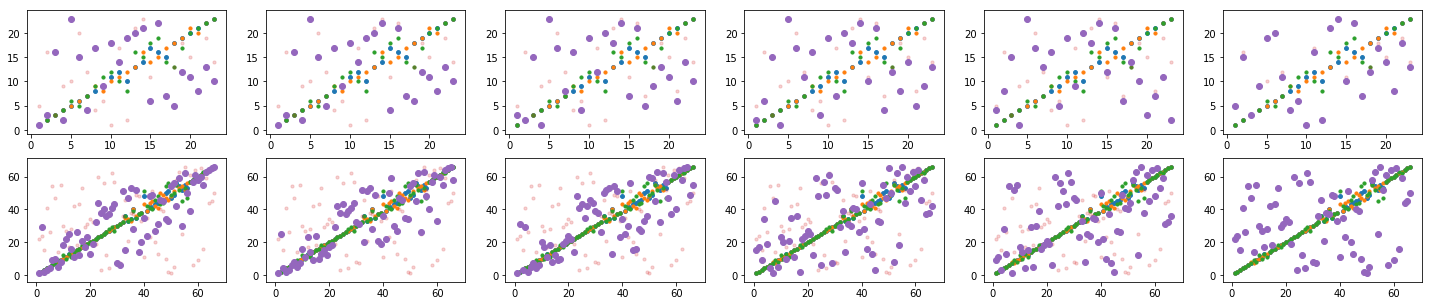

In [183]:
def show_figure():
    params = '0.2 0.5 1 2 4 8'.split()
    f, axs = plt.subplots(2, len(params), figsize=(25,5))
    
    for nidx, nbn in enumerate((1,5)):
        group = explicit.query("nBN == @nbn")
        group = group.sort_values('ccsdpt')
        expected = group.label.values

        
        for pidx, param in enumerate(params):
            ax = axs[nidx][pidx]
            apdft, apdft_groups = parse_ranked("n-%s.log" % param)
            barriers = np.cumsum(apdft_groups)
            actual = [apdft.index(_) for _ in expected]
            barriers = barriers[(barriers >= min(actual)+1) & (barriers <= max(actual)+1)]
            barriers -= min(actual)
            #for b in barriers:
                #ax.axhline(b+.5)

            actual = np.array(actual) - min(actual)
            ranked = group.rank()
            ax.scatter(ranked.ccsdpt, ranked.ccsd, s=15)
            ax.scatter(ranked.ccsdpt, ranked.mp2, s=10)
            ax.scatter(ranked.ccsdpt, ranked.hf, s=10)
            ax.scatter(ranked.ccsdpt, ranked.nn, s=10, alpha=0.2)
            ax.scatter(range(1, len(actual)+1), np.array(actual)+1)
            print (nbn, param, scs.spearmanr(range(1, len(actual)+1), np.array(actual)+1).correlation)
show_figure()

1 0.01 0.09980237154150197
1 2 0.09486166007905138
1 3 0.05237154150197629
1 4 0.05434782608695652
1 4.2 0.3922924901185771
1 4.5 -0.10474308300395258
1 5 -0.06818181818181818
5 0.01 0.853125978499113
5 2 0.8459033503809624
5 3 0.8565076714330447
5 4 0.8586786347980381
5 4.2 0.8593048742302475
5 4.5 0.8475315729047074
5 5 0.6122325435758272


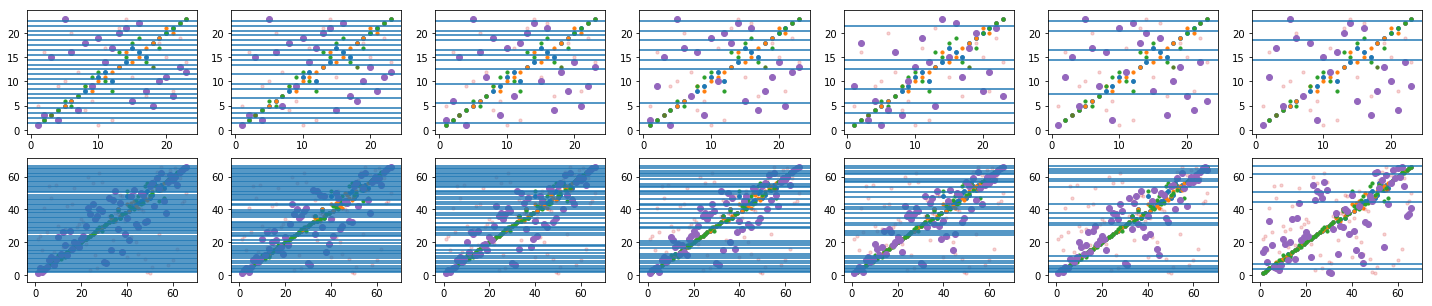

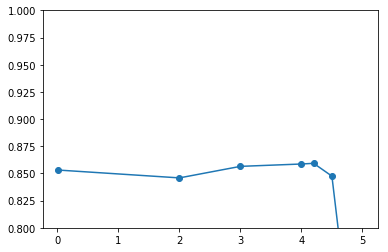

In [202]:
def show_figure():
    params = '0.01 2 3 4 4.2 4.5 5'.split()
    f, axs = plt.subplots(2, len(params), figsize=(25,5))
    
    xs = []
    ys = []
    for nidx, nbn in enumerate((1,5)):
        group = explicit.query("nBN == @nbn")
        group = group.sort_values('ccsdpt')
        expected = group.label.values

        
        for pidx, param in enumerate(params):
            ax = axs[nidx][pidx]
            apdft, apdft_groups = parse_ranked("q-%s.log" % param)
            barriers = np.cumsum(apdft_groups)
            actual = [apdft.index(_) for _ in expected]
            barriers = barriers[(barriers >= min(actual)+1) & (barriers <= max(actual)+1)]
            barriers -= min(actual)
            for b in barriers:
                ax.axhline(b+.5)

            actual = np.array(actual) - min(actual)
            ranked = group.rank()
            ax.scatter(ranked.ccsdpt, ranked.ccsd, s=15)
            ax.scatter(ranked.ccsdpt, ranked.mp2, s=10)
            ax.scatter(ranked.ccsdpt, ranked.hf, s=10)
            ax.scatter(ranked.ccsdpt, ranked.nn, s=10, alpha=0.2)
            ax.scatter(range(1, len(actual)+1), np.array(actual)+1)
            corr = scs.spearmanr(range(1, len(actual)+1), np.array(actual)+1).correlation
            print (nbn, param, corr)
            if nbn == 5:
                xs.append(float(param))
                ys.append(corr)
    plt.show()
    plt.plot(xs, ys, 'o-')
    plt.ylim(0.8, 1.)
show_figure()

5 0.01 0.8310823504853357
5 1 0.8310823504853357


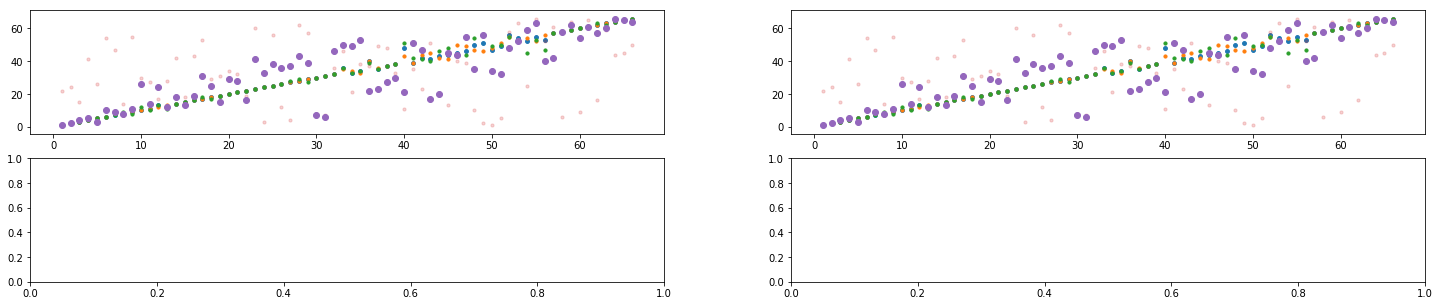

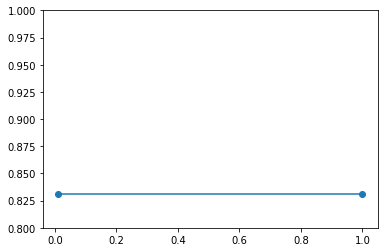

In [249]:
def show_figure():
    params = '0.01 1'.split()
    f, axs = plt.subplots(2, len(params), figsize=(25,5))
    
    xs = []
    ys = []
    for nidx, nbn in enumerate((5,)):
        group = explicit.query("nBN == @nbn")
        group = group.sort_values('ccsd')
        expected = group.label.values

        
        for pidx, param in enumerate(params):
            ax = axs[nidx][pidx]
            apdft, apdft_groups = parse_ranked2("d.log")
            barriers = np.cumsum(apdft_groups)
            lookup = {find_label(_): _ for _ in apdft}
            actual = [apdft.index(lookup[_]) for _ in expected]
            #barriers = barriers[(barriers >= min(actual)+1) & (barriers <= max(actual)+1)]
            #barriers -= min(actual)
            #for b in barriers:
            #    ax.axhline(b+.5)

            actual = np.array(actual) - min(actual)
            ranked = group.rank()
            ax.scatter(ranked.ccsdpt, ranked.ccsd, s=15)
            ax.scatter(ranked.ccsdpt, ranked.mp2, s=10)
            ax.scatter(ranked.ccsdpt, ranked.hf, s=10)
            ax.scatter(ranked.ccsdpt, ranked.nn, s=10, alpha=0.2)
            ax.scatter(range(1, len(actual)+1), np.array(actual)+1)
            corr = scs.spearmanr(range(1, len(actual)+1), np.array(actual)+1).correlation
            print (nbn, param, corr)
            if nbn == 5:
                xs.append(float(param))
                ys.append(corr)
    plt.show()
    plt.plot(xs, ys, 'o-')
    plt.ylim(0.8, 1.)
show_figure()

In [245]:

def old2new(label):
    mapping = [5,4,0,3,6,9,1,2,7,8]
    mapping = [2,6,7,3,1,0,4,8,9,5]
    return ''.join([label[_] for _ in mapping])
def permutations_old(label):
    ret = []
    mapping = [1,0,3,2,5,4,7,6,9,8]
    ret.append(''.join([label[_] for _ in mapping]))
    mapping = [0,1, 4,5, 2,3, 8,9, 6,7,]
    ret.append(''.join([label[_] for _ in mapping]))
    mapping = [1,0,3,2,5,4,7,6,9,8]
    ret.append(''.join([ret[-1][_] for _ in mapping]))
    return ret
def find_label(lbl):
    group = explicit.query("nBN == 5")
    for label in [lbl] + permutations_old(lbl):
        if label in group.label.values:
            return label

In [250]:
find_label('NBBNBNNBNB')

'BNNBNBBNBN'

(array([ 14.,  67., 200., 289., 235., 165.,  53.,  11.,  13.,   9.]),
 array([-393.76165206, -393.67489883, -393.58814559, -393.50139236,
        -393.41463912, -393.32788589, -393.24113265, -393.15437942,
        -393.06762618, -392.98087295, -392.89411971]),
 <a list of 10 Patch objects>)

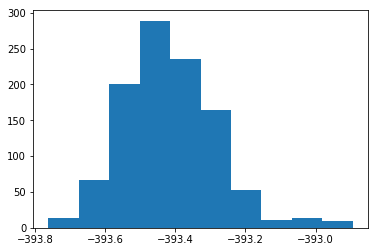

In [255]:
plt.hist(explicit.query("nBN == 3").hf.values)

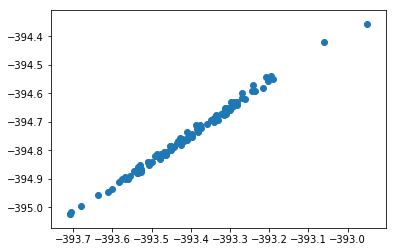

In [261]:
plt.scatter(explicit.query("nBN == 3").hf.values[::10], explicit.query("nBN == 3").ccsd.values[::10])

In [263]:
scs.spearmanr(explicit.query("nBN == 3").hf.values[::], explicit.query("nBN == 3").ccsd.values[::]).correlation

0.9972632441159794

In [309]:
with open("napthalene-molpro") as fh:
    lines = fh.readlines()
news = []
olds = []
labels = []
lookupd = {find_label(_): _ for _ in [_.split('/')[0].split('-')[1] for _ in lines]}
for lbl in explicit.query("nBN == 5").label.values:
    labels.append(lbl)
    for line in lines:
        if lookupd[lbl] in line:
            energy = float(line.strip().split()[-1])
            break
    else:
        raise ValueError(lbl)
    news.append(explicit.query("label == @lbl").ccsd.values[0])
    olds.append(energy)

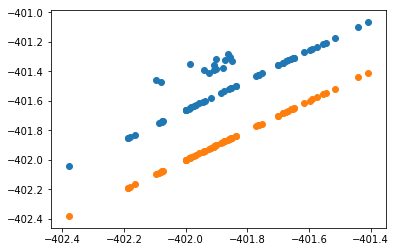

In [311]:
plt.scatter(olds, news)
plt.scatter(olds, olds)

In [304]:
q = (np.array(olds) - np.array(news))
q -= np.median(q)
[labels[_] for _ in np.where(np.abs(q) > 0.01)[0]]

['BBBBNNNNBN',
 'BBBNNNBNBN',
 'BBBNNNBNNB',
 'BBBNNNNBBN',
 'BBBNNNNBNB',
 'BNBBBBNNNN',
 'BNBBNBBNNN',
 'BNBBNNBNBN',
 'BNBBNNBNNB',
 'BNNBNBBBNN',
 'BNNBNNBBBN',
 'BNNBNNBBNB',
 'NNBBBNNNBB',
 'NNBNNBBBBN']

In [312]:
lookupd['BBBBNNNNBN']

'BBNNBBNBNN'

['BBBBNNNBNN',
 'BBBNBBNNNN',
 'BBBNNBNNBN',
 'BBBNNBNNNB',
 'BBBNNNBNBN',
 'BBBNNNNBBN',
 'BBNBNBBNNN',
 'BBNBNBNBNN',
 'BBNBNNNNBB',
 'BBNNBBNBNN',
 'BBNNBNNNBB',
 'BBNNNBBNBN',
 'BBNNNBBNNB',
 'BBNNNNBNBB',
 'BNBBNBNNNB',
 'BNBNBBNNNB',
 'BNBNBNNBBN',
 'BNBNNBBNBN',
 'BNBNNNBBBN',
 'BNNBBBNNBN',
 'BNNBBNBNNB',
 'BNNBBNNBNB',
 'BNNBNBBBNN',
 'BNNBNBNBBN',
 'BNNBNNBBBN',
 'BNNNBBBBNN',
 'BNNNBBNBNB',
 'BNNNBBNNBB',
 'BNNNBNBBNB',
 'BNNNNBBBNB',
 'BNNNNBNBBB',
 'NBBBBBNNNN',
 'NBBBNBNNNB',
 'NBBBNNBNNB',
 'NBBBNNNBBN',
 'NBBBNNNBNB',
 'NBBNBBNBNN',
 'NBBNBBNNBN',
 'NBBNBNBNBN',
 'NBBNBNNBNB',
 'NBBNNBBBNN',
 'NBBNNBBNNB',
 'NBNBBBBNNN',
 'NBNBBBNNNB',
 'NBNBBNBBNN',
 'NBNBNBBNBN',
 'NBNBNBNBNB',
 'NBNBNBNNBB',
 'NBNBNNBBBN',
 'NBNBNNNBBB',
 'NBNNBNBBNB',
 'NBNNNNBBBB',
 'NNBBBBNNBN',
 'NNBBBNBNBN',
 'NNBBNBBBNN',
 'NNBBNBNBBN',
 'NNBBNNBBNB',
 'NNBBNNBNBB',
 'NNBNBBBBNN',
 'NNBNBBBNNB',
 'NNBNBNBNBB',
 'NNBNBNNBBB',
 'NNBNNBBBBN',
 'NNBNNBBBNB',
 'NNNBBBBNBN',
 'NNNNBNBBBB']